ASRT analysis
--

Basic ASRT analysis script for the output file generated with the script of the *ASRT_Python* repository

**Created by Teodóra Vékony (Gran Canaria Cognitive Research Center)**

teodora.vekony@pdi.atlanticomedio.es

gccognitive.es

teodoravekony.com

github.com/vekteo

In [22]:
rm(list = ls())

library(ggplot2)
library(readr)
library(lme4)
library(afex)
library(dplyr)
library(tidyr)
library(moments)

options(scipen = 999)
set.seed(500)
set_sum_contrasts()

setting contr.sum globally: options(contrasts=c('contr.sum', 'contr.poly'))



Loading data
--

In [23]:
# list all CSV files in the data directory
files <- list.files(path = "sample_data", pattern = "*.csv", full.names = TRUE)
print(files)

[1] "sample_data/sample1.csv" "sample_data/sample2.csv"
[3] "sample_data/sample3.csv" "sample_data/sample4.csv"


In [24]:
# read and combine all CSV files into one data frame
# specify column types to ensure consistency across files
col_types <- cols(
  participant = col_character(),
  session = col_double(),
  block_number = col_double(),
  trial_number = col_double(),
  trial_in_block_num = col_double(),
  trial_type = col_character(),
  triplet_type = col_character(),
  correct_key_pressed = col_character(),
  response_key_pressed = col_character(),
  sequence_used = col_number(),
  correct_response = col_logical(),
  is_nogo = col_logical(),
  is_practice = col_logical(),
  .default = col_guess()
)

data <- lapply(files, read_csv, col_types = col_types, show_col_types = FALSE) %>% bind_rows()

Preprocessing
--

In [25]:
# replace correct_response values: TRUE with 1 and FALSE with 0
data$correct_response <- ifelse(data$correct_response == TRUE, 1, 0)

In [26]:
# remove non-first responses
asrt <- data %>%
  filter(is_first_response == 1)

In [27]:
# remove first trials of blocks, repetitions, trills
asrt <- asrt %>% filter(triplet_type != "X" & triplet_type != "R" & triplet_type != "T")

In [28]:
head(asrt)

participant,session,block_number,trial_number,trial_in_block_num,trial_type,triplet_type,sequence_used,stimulus_position_num,rt_non_cumulative_s,⋯,response_key_pressed,correct_response,is_nogo,is_practice,epoch,is_first_response,mind_wandering_rating_1,mind_wandering_rating_2,mind_wandering_rating_3,mind_wandering_rating_4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0001,1,1,3,3,R,L,1234,1,0.3106739,⋯,s,1,FALSE,FALSE,1,1,2,2,1,3
0001,1,1,4,4,P,H,1234,2,0.4155201,⋯,f,1,FALSE,FALSE,1,1,2,2,1,3
0001,1,1,5,5,R,L,1234,4,0.3681558,⋯,l,1,FALSE,FALSE,1,1,2,2,1,3
0001,1,1,6,6,P,H,1234,3,0.4348689,⋯,j,1,FALSE,FALSE,1,1,2,2,1,3
0001,1,1,7,7,R,H,1234,1,0.3803243,⋯,s,1,FALSE,FALSE,1,1,2,2,1,3
0001,1,1,8,8,P,H,1234,4,0.3868619,⋯,l,1,FALSE,FALSE,1,1,2,2,1,3


Checking data distribution before filtering
--

[1] "Skewness of RT distribution: 83.4752035191254"


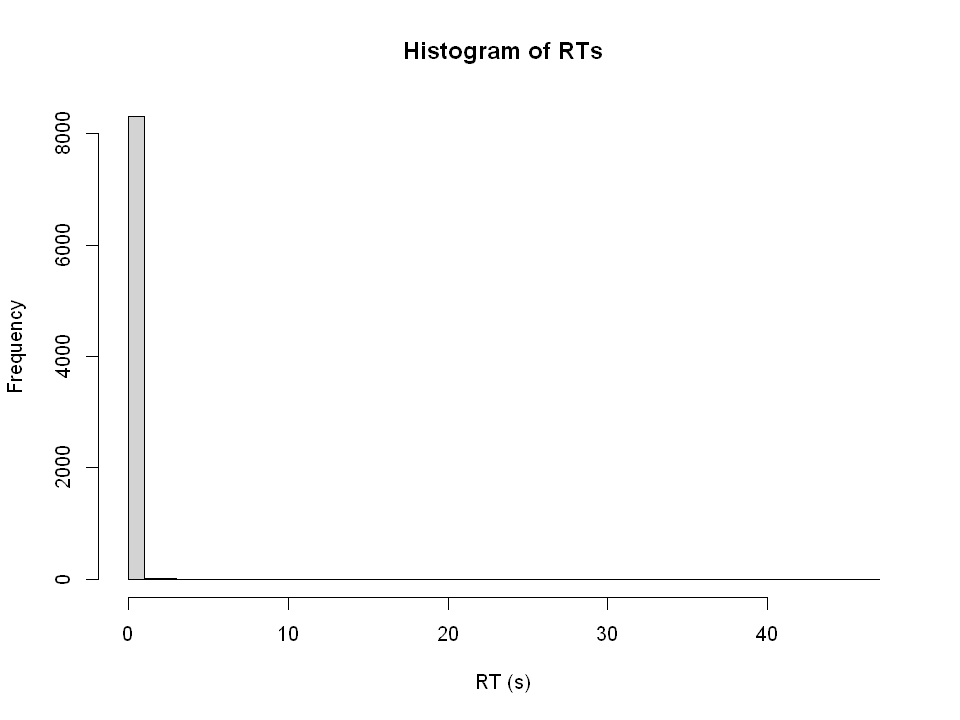

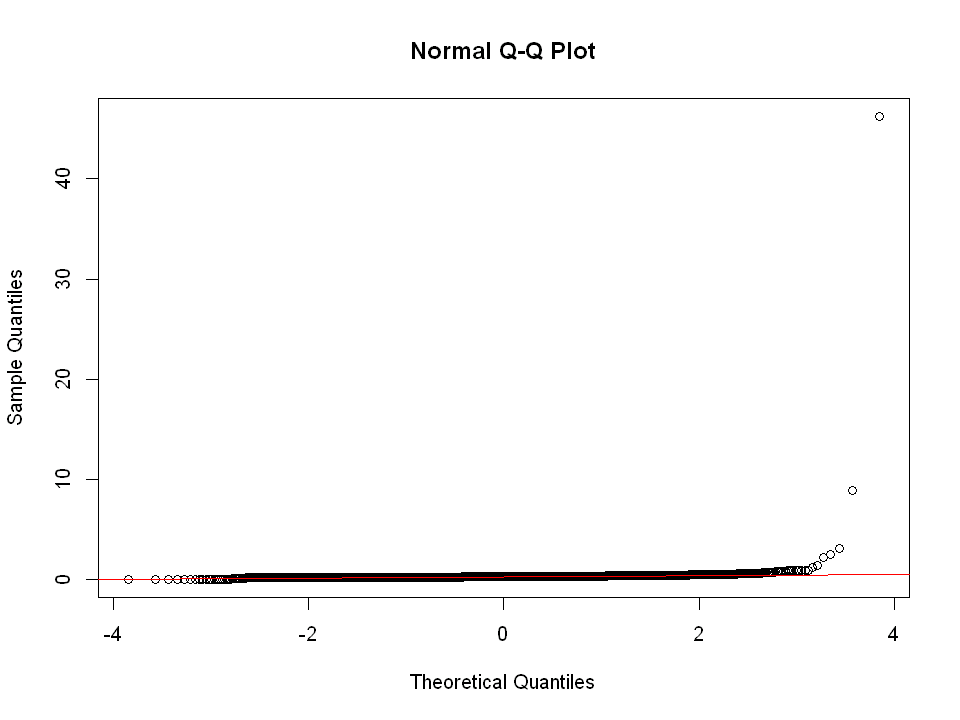

In [29]:
options(repr.plot.width = 8, repr.plot.height = 6)

# visualize RT distribution, QQplot, and calculate skewness
hist(asrt$rt_cumulative_s, breaks = 50, main = "Histogram of RTs", xlab = "RT (s)")
 
skewness_value <- skewness(asrt$rt_cumulative_s, na.rm = TRUE)
print(paste("Skewness of RT distribution:", skewness_value))

qqnorm(asrt$rt_cumulative_s)
qqline(asrt$rt_cumulative_s, col = "red")

Filtering outliers
--

In [30]:
# remove outlier RTs based on individual median absolute deviation (MAD) method
asrt <- asrt %>%
  group_by(participant) %>%
  filter(rt_cumulative_s > median(rt_cumulative_s, na.rm = TRUE) - 3 * mad(rt_cumulative_s, na.rm = TRUE) & 
         rt_cumulative_s < median(rt_cumulative_s, na.rm = TRUE) + 3 * mad(rt_cumulative_s, na.rm = TRUE)) %>%
  ungroup()

# filter extreme outliers - keep RTs between 100 ms and 1000 ms
asrt <- asrt %>% filter(rt_cumulative_s > 0.1 & rt_cumulative_s < 1)

In [31]:
# prepare accuracy data frame (with inaccurate responses)
asrt_ACC <- asrt

In [32]:
# keep only correct responses
asrt <- asrt %>% filter(correct_response == 1)

Checking data distribution after filtering
--

*Normality test will almost always show deviation for normality due to the high number of trials in the ASRT task*

[1] "Skewness of RT distribution: 1.01265970936053"


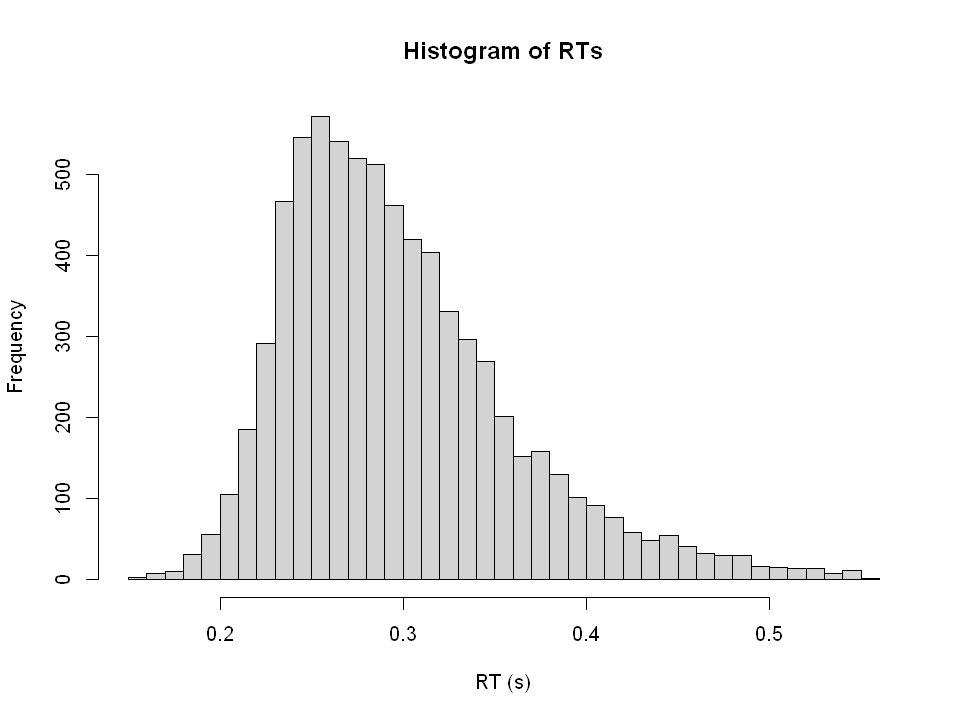

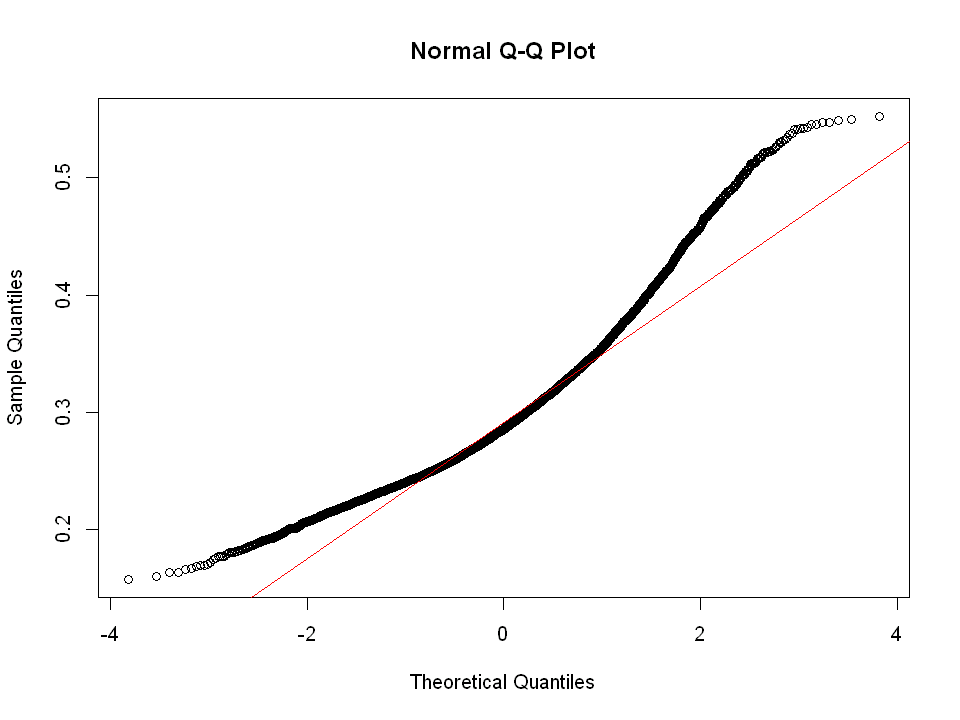

In [33]:
options(repr.plot.width = 8, repr.plot.height = 6)

# visualize RT distribution, QQplot, and calculate skewness
hist(asrt$rt_cumulative_s, breaks = 50, main = "Histogram of RTs", xlab = "RT (s)")
 
skewness_value <- skewness(asrt$rt_cumulative_s, na.rm = TRUE)
print(paste("Skewness of RT distribution:", skewness_value))

qqnorm(asrt$rt_cumulative_s)
qqline(asrt$rt_cumulative_s, col = "red")

In [34]:
# OPTINAL: log-transform of RTs if skewness is still high after outlier removal (e.g., > 0.5 or 1)
#asrt$rt_cumulative_s <- log(asrt$rt_cumulative_s)

Visualization
--

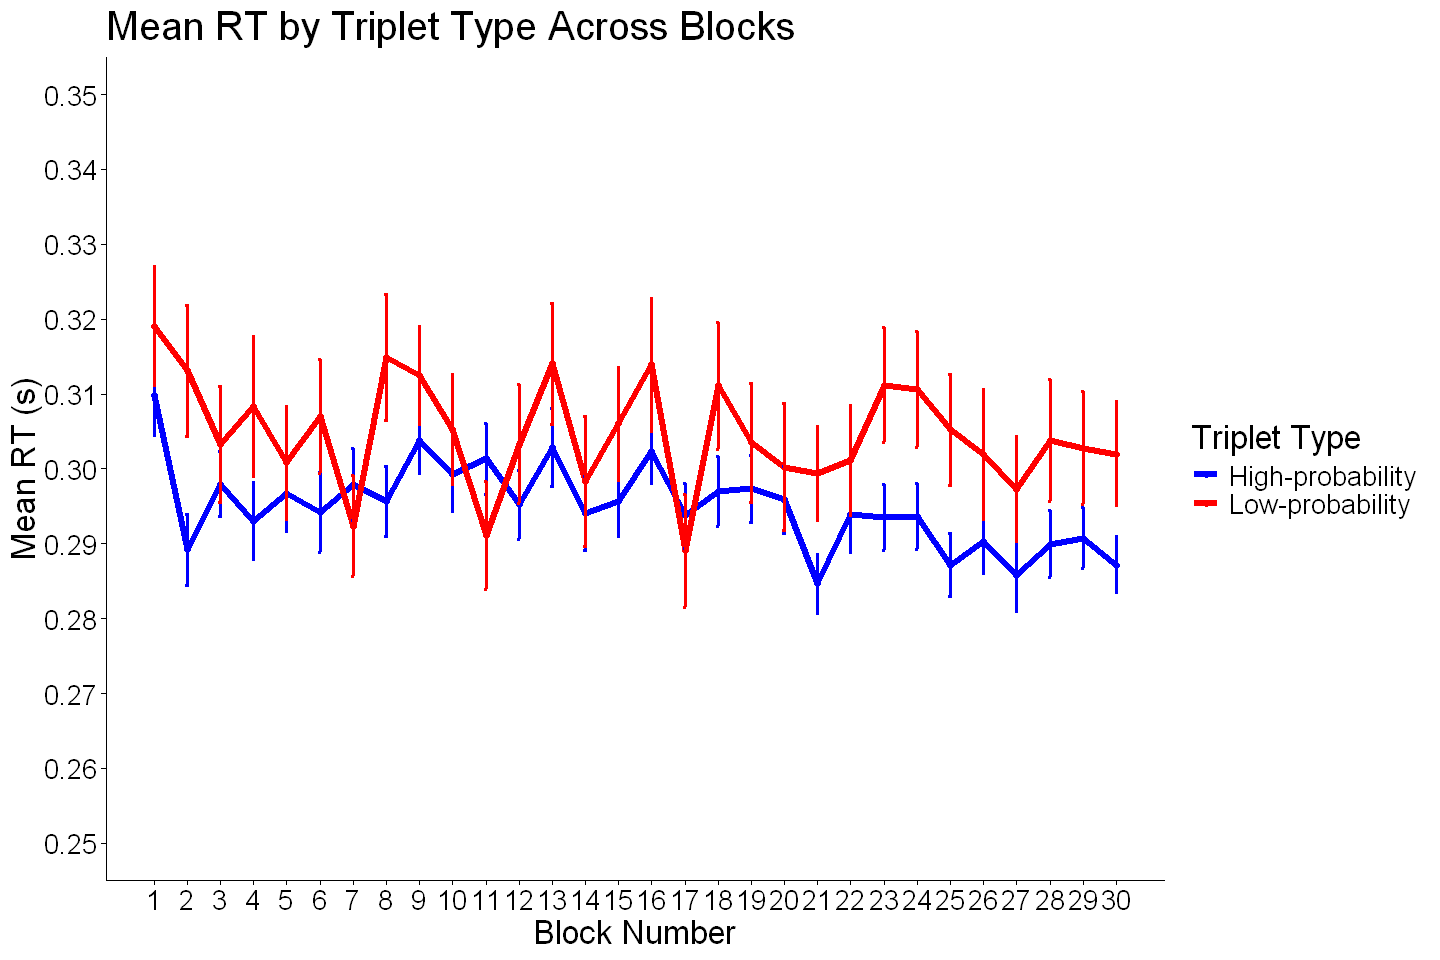

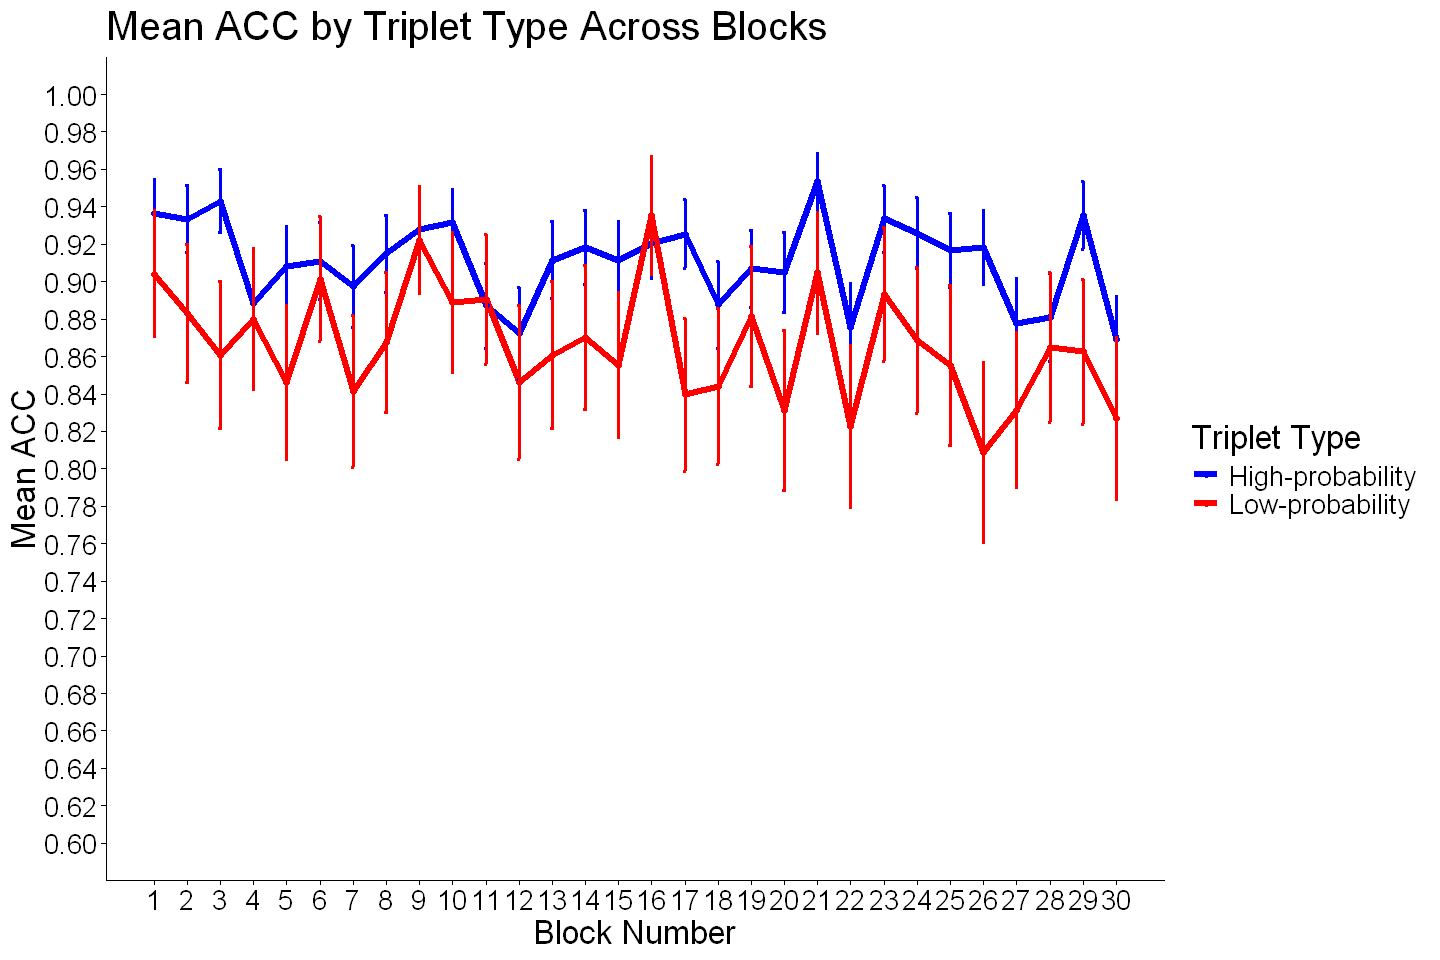

In [35]:
  ## RT analysis
  
  asrt_summary <- asrt %>%
    group_by(triplet_type, block_number) %>%
    summarise(mean_RT = mean(rt_cumulative_s, na.rm = TRUE),
              se_RT = sd(rt_cumulative_s, na.rm = TRUE) / sqrt(n()),
              .groups = "drop")
  
  options(repr.plot.width = 12, repr.plot.height = 8)
  
  ggplot(asrt_summary, aes(x = block_number, y = mean_RT, color = triplet_type, group = triplet_type)) +
      geom_line(linewidth = 1.8) +
      geom_point() +
      geom_errorbar(aes(ymin = mean_RT - se_RT, ymax = mean_RT + se_RT), linewidth = 1, width = 0.1) +
      labs(title = "Mean RT by Triplet Type Across Blocks",
           x = "Block Number",
           y = "Mean RT (s)",
           color = "Triplet Type") +
      theme_classic() + 
      theme(text = element_text(size = 20)) +        
      scale_color_manual(values = c("H" = "blue", "L" = "red"),
                         labels = c("High-probability", "Low-probability")) +
      scale_y_continuous(limits = c(0.25, 0.35), breaks = seq(0.25, 0.35, by = 0.01)) +
      scale_x_continuous(limits = c(1, 30), breaks = seq(1, 30, by = 1))


# Accuracy analysis

  asrt_summary_ACC <- asrt_ACC %>%
    group_by(triplet_type, block_number) %>%
    summarise(mean_ACC = mean(correct_response, na.rm = TRUE),
              se_ACC = sd(correct_response, na.rm = TRUE) / sqrt(n()),
              .groups = "drop")
  
  ggplot(asrt_summary_ACC, aes(x = block_number, y = mean_ACC, color = triplet_type, group = triplet_type)) +
      geom_line(linewidth = 1.8) +
      geom_point() +
      geom_errorbar(aes(ymin = mean_ACC - se_ACC, ymax = mean_ACC + se_ACC), linewidth = 1, width = 0.1) +
      labs(title = "Mean ACC by Triplet Type Across Blocks",
           x = "Block Number",
           y = "Mean ACC",
           color = "Triplet Type") +
      theme_classic() + 
      theme(text = element_text(size = 20)) +        
      scale_color_manual(values = c("H" = "blue", "L" = "red"),
                         labels = c("High-probability", "Low-probability")) +
      scale_y_continuous(limits = c(0.60, 1), breaks = seq(0.60, 1, by = 0.02)) +
      scale_x_continuous(limits = c(1, 30), breaks = seq(1, 30, by = 1))

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


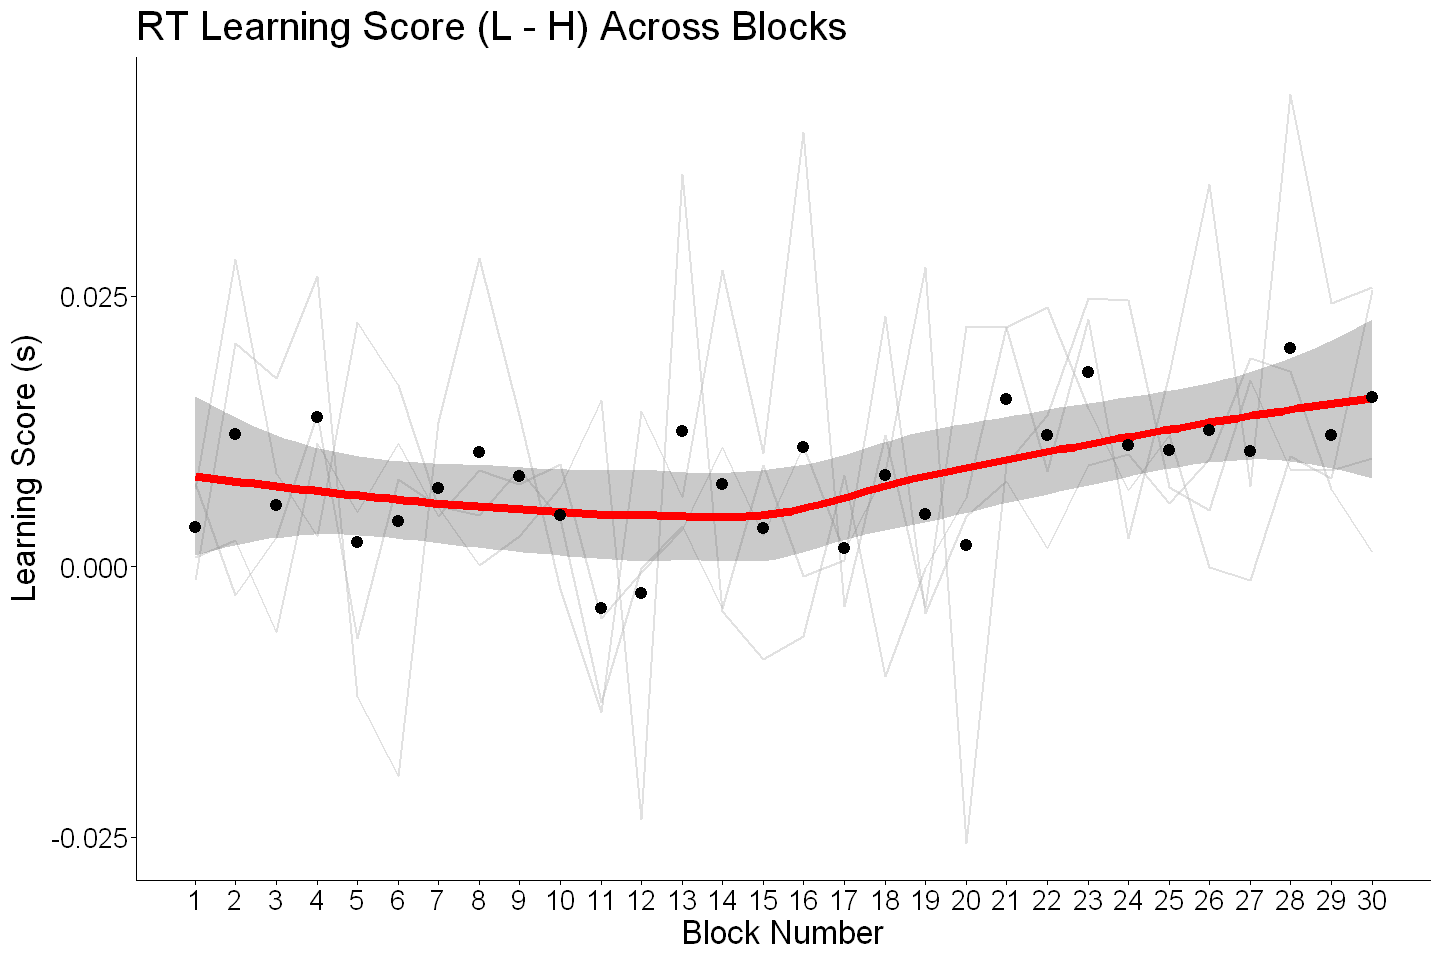

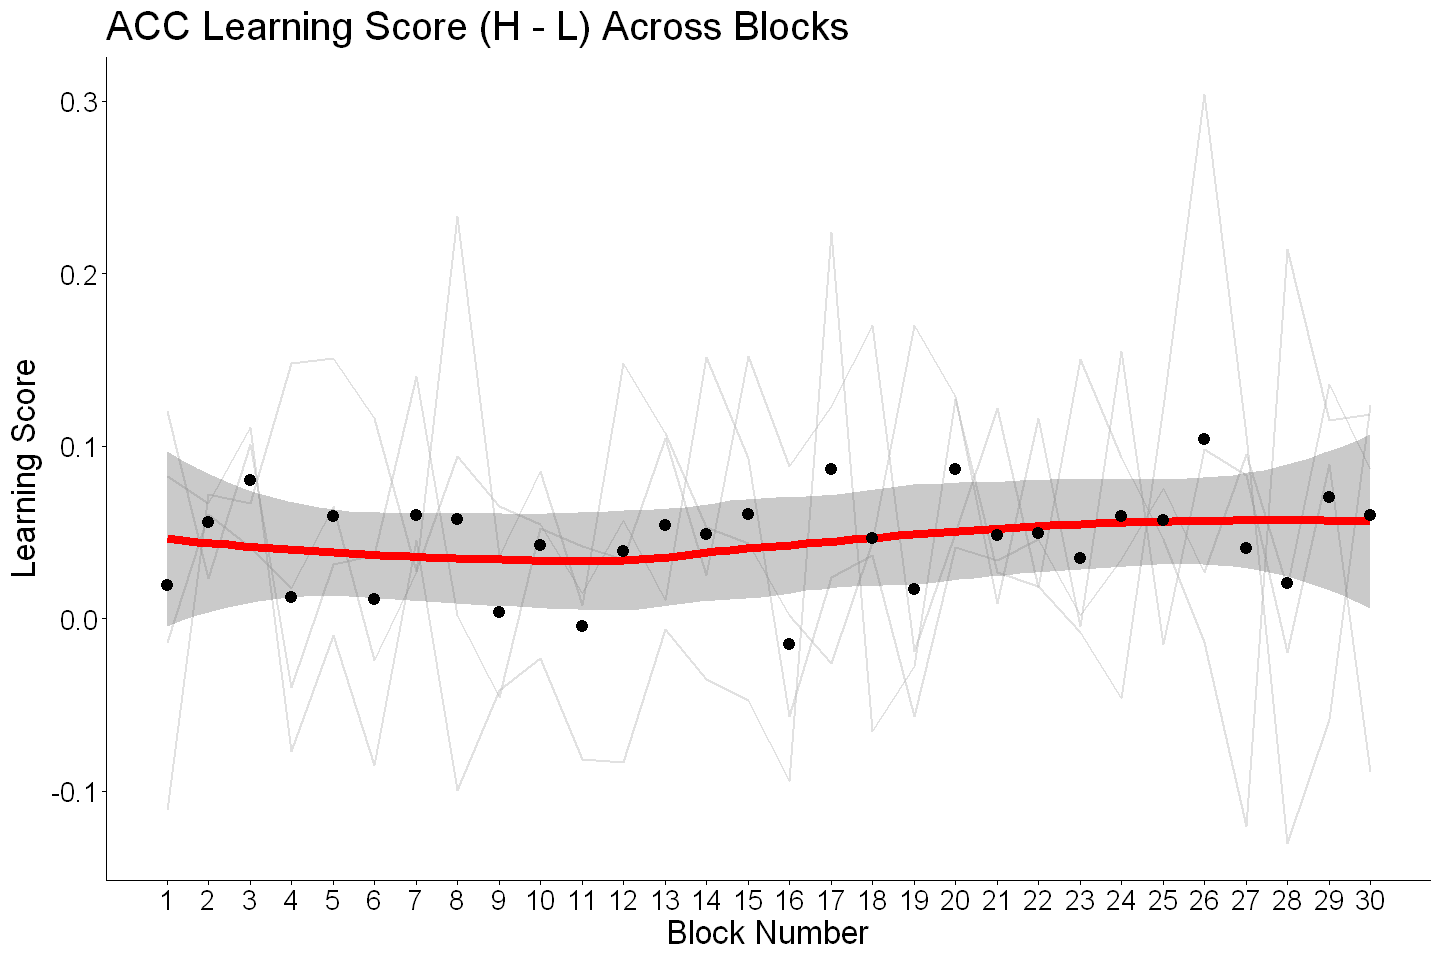

In [36]:
# RT analysis with learning scores (L - H)

learning_scores <- asrt %>%
    group_by(participant, block_number, triplet_type) %>%
    summarise(mean_RT = mean(rt_cumulative_s, na.rm = TRUE),
              .groups = "drop") %>%
    pivot_wider(names_from = triplet_type, values_from = mean_RT, names_prefix = "mean_RT_") %>%
    mutate(learning_score = mean_RT_L - mean_RT_H)

learning_summary <- learning_scores %>%
    group_by(block_number) %>%
    summarise(mean_learning = mean(learning_score, na.rm = TRUE),
                        se_learning = sd(learning_score, na.rm = TRUE) / sqrt(n()),
                        .groups = "drop")

options(repr.plot.width = 12, repr.plot.height = 8)

ggplot() +
    geom_line(data = learning_scores, aes(x = block_number, y = learning_score, group = participant),
                        alpha = 0.4, color = "gray70", linewidth = 0.8) +
    geom_smooth(data = learning_scores, aes(x = block_number, y = learning_score),
                         method = "loess", se = TRUE, color = "red", linewidth = 2.5,
                         fill = "gray30", alpha = 0.3) +
    geom_point(data = learning_summary, aes(x = block_number, y = mean_learning), 
                        size = 3, color = "black") +
    labs(title = "RT Learning Score (L - H) Across Blocks",
             x = "Block Number",
             y = "Learning Score (s)") +
    theme_classic() +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(limits = c(1, 30), breaks = seq(1, 30, by = 1))

# Accuracy analysis with learning scores (L - H)
learning_scores_ACC <- asrt_ACC %>%
    group_by(participant, block_number, triplet_type) %>%
    summarise(mean_ACC = mean(correct_response, na.rm = TRUE),
              .groups = "drop") %>%
    pivot_wider(names_from = triplet_type, values_from = mean_ACC, names_prefix = "mean_ACC_") %>%
    mutate(learning_score_ACC = mean_ACC_H - mean_ACC_L)

learning_summary_ACC <- learning_scores_ACC %>%
    group_by(block_number) %>%
    summarise(mean_learning = mean(learning_score_ACC, na.rm = TRUE),
                        se_learning = sd(learning_score_ACC, na.rm = TRUE) / sqrt(n()),
                        .groups = "drop")

options(repr.plot.width = 12, repr.plot.height = 8)

ggplot() +
    geom_line(data = learning_scores_ACC, aes(x = block_number, y = learning_score_ACC, group = participant),
                        alpha = 0.4, color = "gray70", linewidth = 0.8) +
    geom_smooth(data = learning_scores_ACC, aes(x = block_number, y = learning_score_ACC),
                         method = "loess", se = TRUE, color = "red", linewidth = 2.5,
                         fill = "gray30", alpha = 0.3) +
    geom_point(data = learning_summary_ACC, aes(x = block_number, y = mean_learning), 
                        size = 3, color = "black") +
    labs(title = "ACC Learning Score (H - L) Across Blocks",
             x = "Block Number",
             y = "Learning Score") +
    theme_classic() +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(limits = c(1, 30), breaks = seq(1, 30, by = 1))


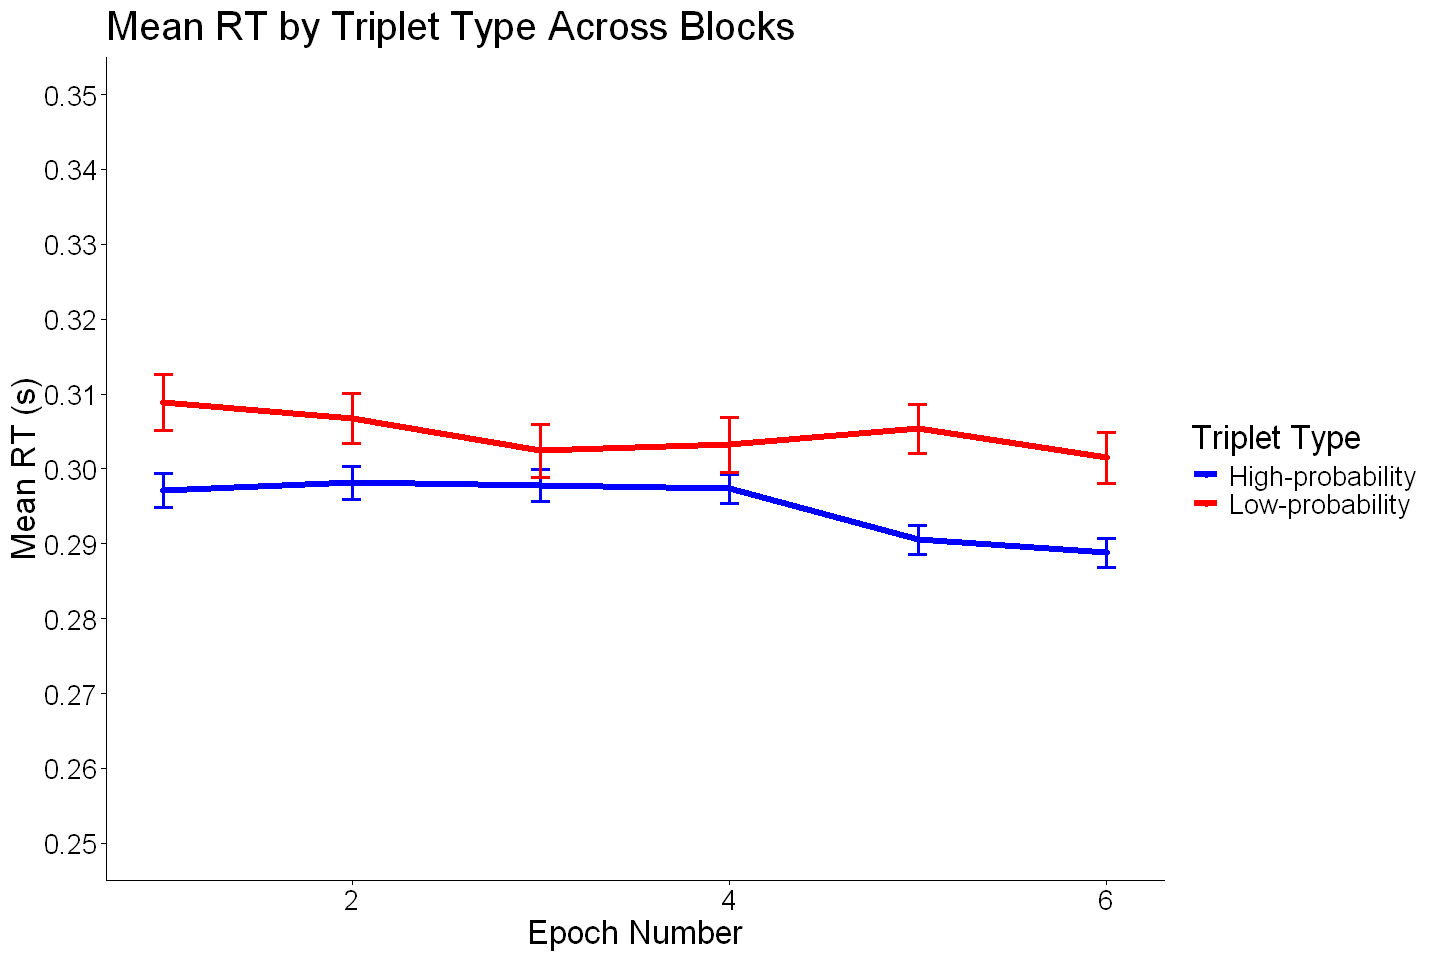

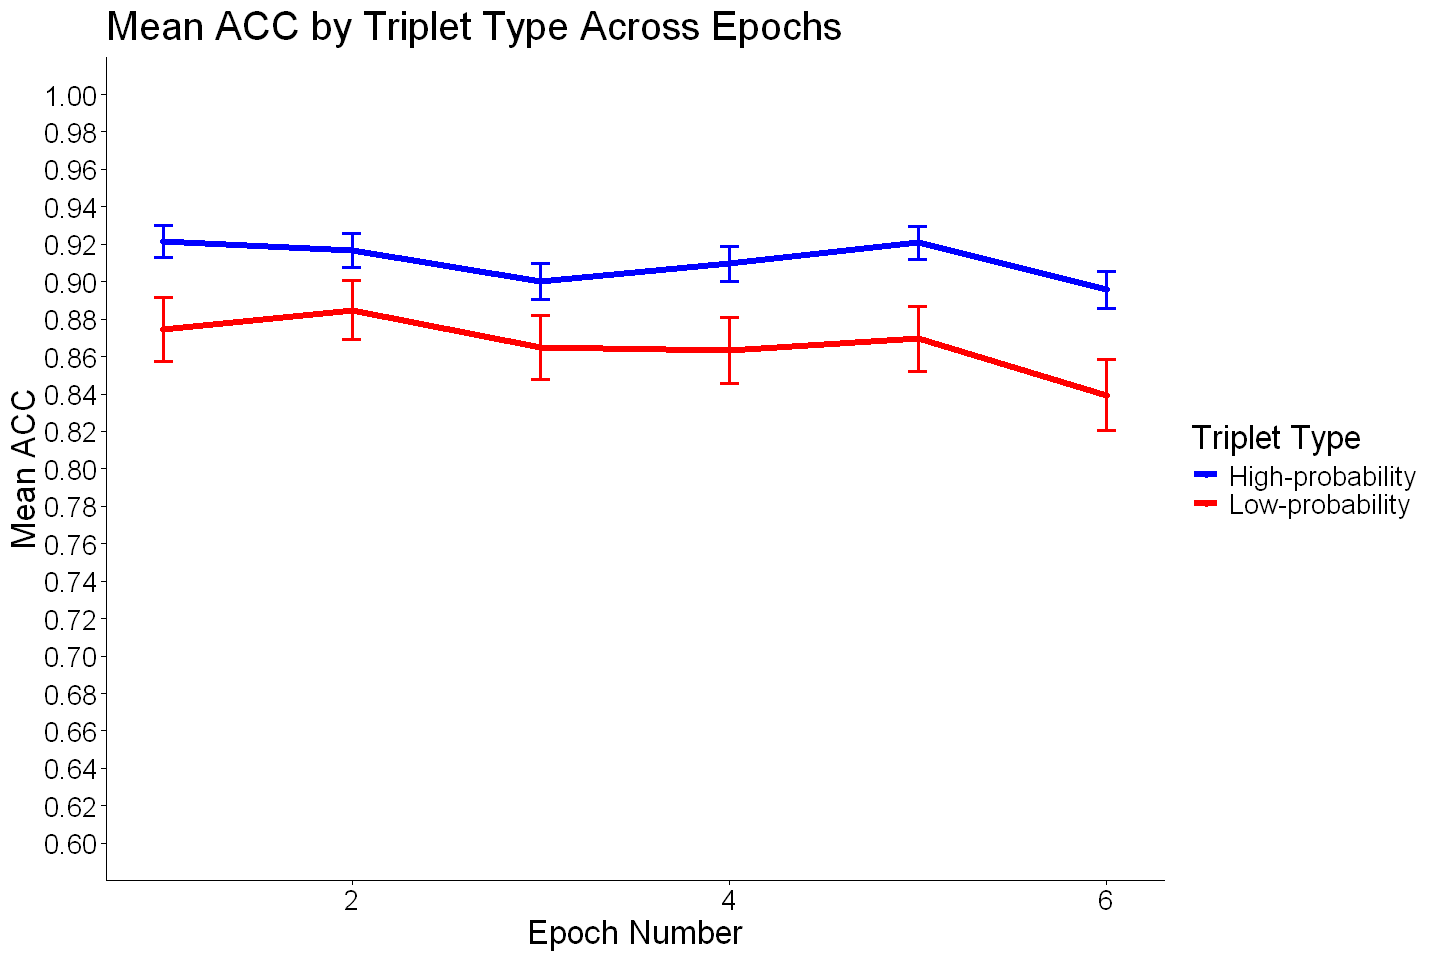

In [37]:
# RT analysis by epoch (instead of block)
  
  asrt_summary <- asrt %>%
    group_by(triplet_type, epoch) %>%
    summarise(mean_RT = mean(rt_cumulative_s, na.rm = TRUE),
              se_RT = sd(rt_cumulative_s, na.rm = TRUE) / sqrt(n()),
              .groups = "drop")
  
  options(repr.plot.width = 12, repr.plot.height = 8)
  
  ggplot(asrt_summary, aes(x = epoch, y = mean_RT, color = triplet_type, group = triplet_type)) +
      geom_line(linewidth = 1.8) +
      geom_point() +
      geom_errorbar(aes(ymin = mean_RT - se_RT, ymax = mean_RT + se_RT), linewidth = 1, width = 0.1) +
      labs(title = "Mean RT by Triplet Type Across Blocks",
           x = "Epoch Number",
           y = "Mean RT (s)",
           color = "Triplet Type") +
      theme_classic() + 
      theme(text = element_text(size = 20)) +        
      scale_color_manual(values = c("H" = "blue", "L" = "red"),
                         labels = c("High-probability", "Low-probability")) +
      scale_y_continuous(limits = c(0.25, 0.35), breaks = seq(0.25, 0.35, by = 0.01))

# Accuracy analysis by epoch (instead of block)
  
  asrt_summary_ACC <- asrt_ACC %>%
    group_by(triplet_type, epoch) %>%
    summarise(mean_ACC = mean(correct_response, na.rm = TRUE),
              se_ACC = sd(correct_response, na.rm = TRUE) / sqrt(n()),
              .groups = "drop")
  
  ggplot(asrt_summary_ACC, aes(x = epoch, y = mean_ACC, color = triplet_type, group = triplet_type)) +
      geom_line(linewidth = 1.8) +
      geom_point() +
      geom_errorbar(aes(ymin = mean_ACC - se_ACC, ymax = mean_ACC + se_ACC), linewidth = 1, width = 0.1) +
      labs(title = "Mean ACC by Triplet Type Across Epochs",
           x = "Epoch Number",
           y = "Mean ACC",
           color = "Triplet Type") +
      theme_classic() + 
      theme(text = element_text(size = 20)) +        
      scale_color_manual(values = c("H" = "blue", "L" = "red"),
                         labels = c("High-probability", "Low-probability")) +
      scale_y_continuous(limits = c(0.60, 1), breaks = seq(0.60, 1, by = 0.02))

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


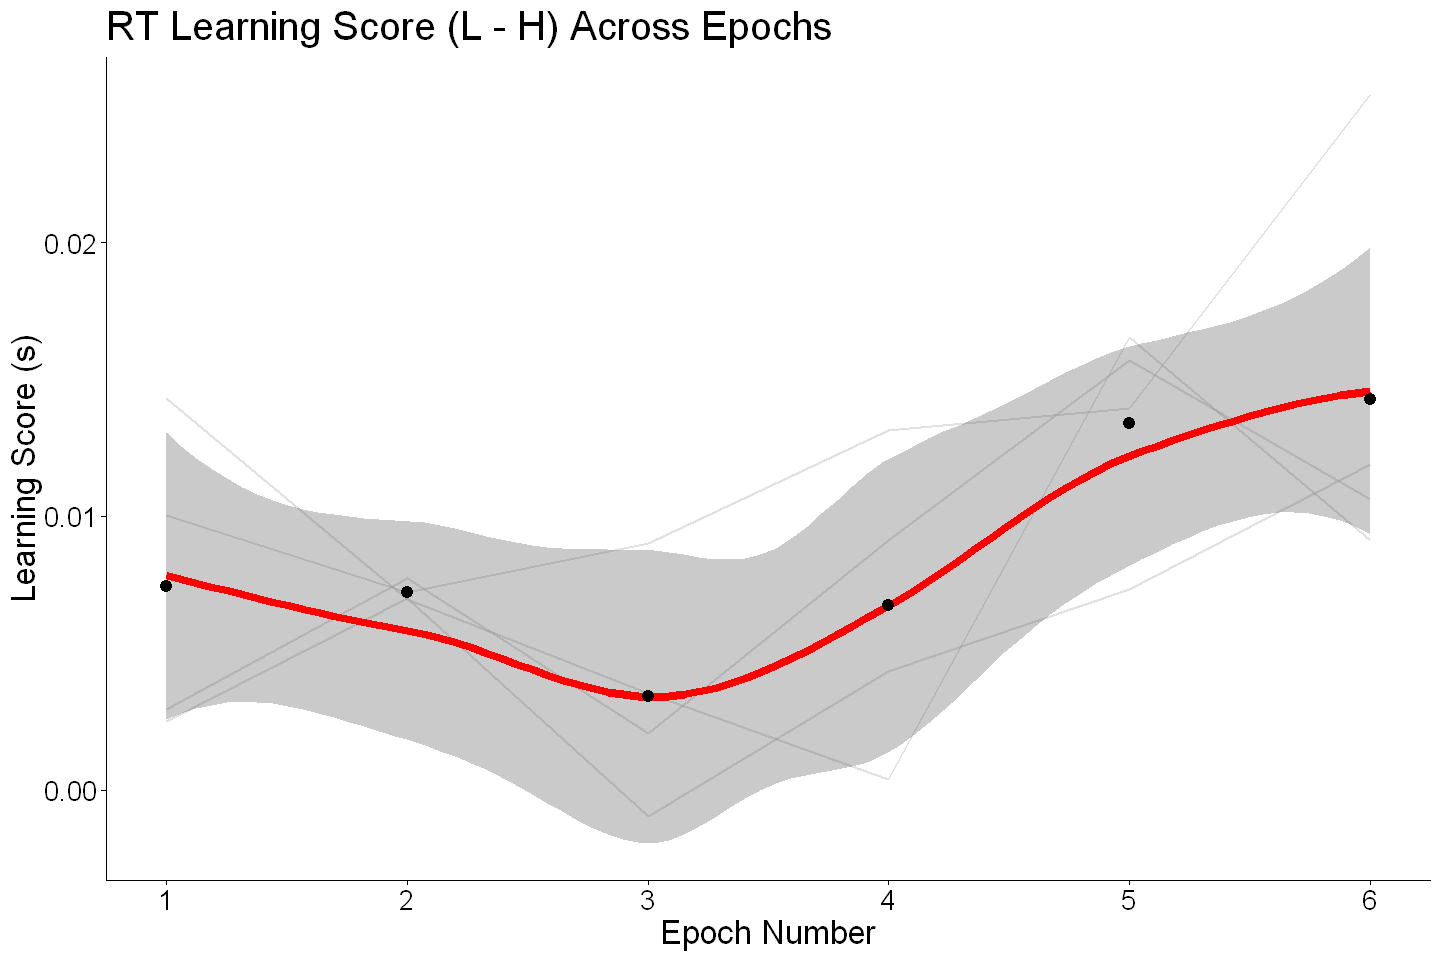

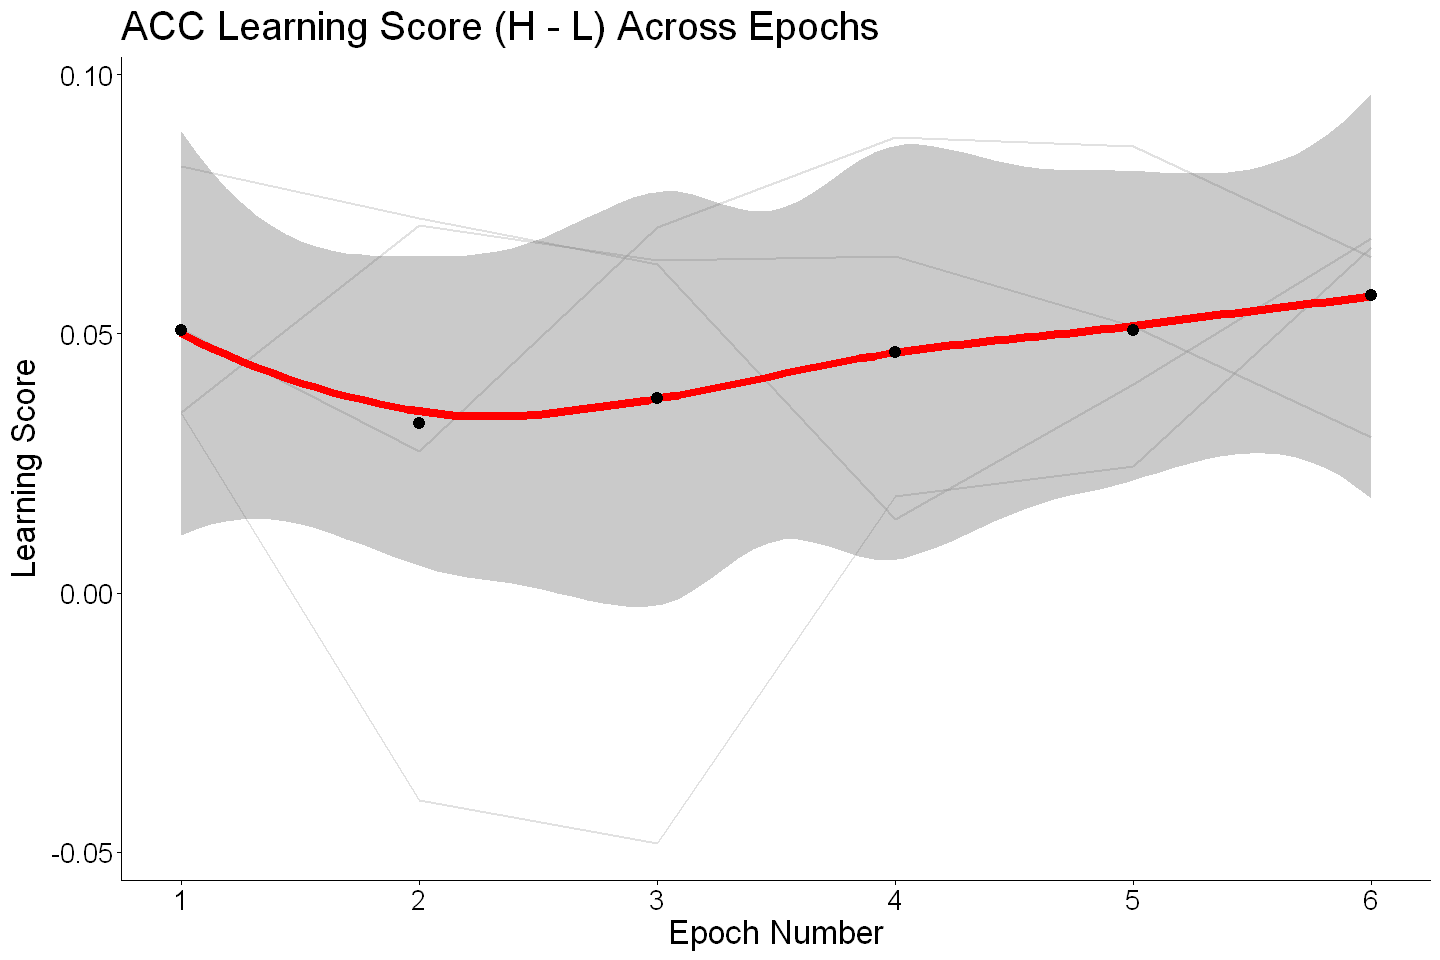

In [38]:
# RT analysis with learning scores (L - H) by epoch

learning_scores <- asrt %>%
    group_by(participant, epoch, triplet_type) %>%
    summarise(mean_RT = mean(rt_cumulative_s, na.rm = TRUE),
              .groups = "drop") %>%
    pivot_wider(names_from = triplet_type, values_from = mean_RT, names_prefix = "mean_RT_") %>%
    mutate(learning_score = mean_RT_L - mean_RT_H)

learning_scores$epoch_num <- as.numeric(as.character(learning_scores$epoch))

learning_summary <- learning_scores %>%
    group_by(epoch, epoch_num) %>%
    summarise(mean_learning = mean(learning_score, na.rm = TRUE),
                        se_learning = sd(learning_score, na.rm = TRUE) / sqrt(n()),
                        .groups = "drop")

options(repr.plot.width = 12, repr.plot.height = 8)

ggplot() +
    geom_line(data = learning_scores, aes(x = epoch_num, y = learning_score, group = participant),
                        alpha = 0.4, color = "gray70", linewidth = 0.8) +
    geom_smooth(data = learning_scores, aes(x = epoch_num, y = learning_score),
                         method = "loess", se = TRUE, color = "red", linewidth = 2.5,
                         fill = "gray30", alpha = 0.3) +
    geom_point(data = learning_summary, aes(x = epoch_num, y = mean_learning), 
                        size = 3, color = "black") +
    labs(title = "RT Learning Score (L - H) Across Epochs",
             x = "Epoch Number",
             y = "Learning Score (s)") +
    scale_x_continuous(breaks = unique(learning_summary$epoch_num)) +
    theme_classic() +
    theme(text = element_text(size = 20))

# Accuracy analysis with learning scores (H - L) by epoch

learning_scores_ACC <- asrt_ACC %>%
    group_by(participant, epoch, triplet_type) %>%
    summarise(mean_ACC = mean(correct_response, na.rm = TRUE),
              .groups = "drop") %>%
    pivot_wider(names_from = triplet_type, values_from = mean_ACC, names_prefix = "mean_ACC_") %>%
    mutate(learning_score_ACC = mean_ACC_H - mean_ACC_L)

learning_scores_ACC$epoch_num <- as.numeric(as.character(learning_scores_ACC$epoch))

learning_summary_ACC <- learning_scores_ACC %>%
    group_by(epoch, epoch_num) %>%
    summarise(mean_learning = mean(learning_score_ACC, na.rm = TRUE),
                        se_learning = sd(learning_score_ACC, na.rm = TRUE) / sqrt(n()),
                        .groups = "drop")

options(repr.plot.width = 12, repr.plot.height = 8)

ggplot() +
    geom_line(data = learning_scores_ACC, aes(x = epoch_num, y = learning_score_ACC, group = participant),
                        alpha = 0.4, color = "gray70", linewidth = 0.8) +
    geom_smooth(data = learning_scores_ACC, aes(x = epoch_num, y = learning_score_ACC),
                         method = "loess", se = TRUE, color = "red", linewidth = 2.5,
                         fill = "gray30", alpha = 0.3) +
    geom_point(data = learning_summary_ACC, aes(x = epoch_num, y = mean_learning), 
                        size = 3, color = "black") +
    labs(title = "ACC Learning Score (H - L) Across Epochs",
             x = "Epoch Number",
             y = "Learning Score") +
    scale_x_continuous(breaks = unique(learning_summary_ACC$epoch_num)) +
    theme_classic() +
    theme(text = element_text(size = 20))

Preparing variables for analysis
--

In [39]:
asrt$block_number_c <- scale(asrt$block_number, center = TRUE, scale = FALSE)
asrt$triplet_type_type <- as.factor(asrt$triplet_type)
asrt$epoch <- as.factor(asrt$epoch)

Statistical analysis
--

* **triplet_type main effect:** difference between high- vs. low-probability triplets - indicates statistical learning

* **epoch main effect:** difference between epochs (chunck of five blocks) - indicates visuomotor performance change over time

* **triplet type by epoch interaction:** difference in the dynamics of statistical learning (how high-low difference changes over epochs)

Repated-measures ANOVA

In [40]:
# repeated measures ANOVA - RTs
model <- aov_ez(id = "participant", 
                dv = "rt_cumulative_s", 
                data = asrt, 
                within = c("triplet_type", "epoch"),
                fun_aggregate = mean)
print(model)

# repeated measures ANOVA - ACC
model_ACC <- aov_ez(id = "participant",
                dv = "correct_response",
                data = asrt_ACC,
                within = c("triplet_type", "epoch"),
                fun_aggregate = mean)
print(model_ACC)

Anova Table (Type 3 tests)

Response: rt_cumulative_s
              Effect    df  MSE       F  ges p.value
1       triplet_type  1, 3 0.00 29.32 * .009    .012
2              epoch 5, 15 0.00    0.30 .001    .906
3 triplet_type:epoch 5, 15 0.00  3.82 * .002    .020
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '+' 0.1 ' ' 1

Sphericity correction method: GG 
Anova Table (Type 3 tests)

Response: correct_response
              Effect    df  MSE       F  ges p.value
1       triplet_type  1, 3 0.00 13.64 * .319    .034
2              epoch 5, 15 0.00    0.51 .099    .767
3 triplet_type:epoch 5, 15 0.00    0.33 .016    .888
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '+' 0.1 ' ' 1

Sphericity correction method: GG 


Linear Mixed Model - RT

In [41]:
# mean-center and create factors for LMM
asrt$block_number_c <- scale(asrt$block_number, center = TRUE, scale = FALSE)
asrt$triplet_type <- as.factor(asrt$triplet_type)
asrt$epoch <- as.factor(asrt$epoch)

asrt_ACC$block_number_c <- scale(asrt_ACC$block_number, center = TRUE, scale = FALSE)
asrt_ACC$triplet_type <- as.factor(asrt_ACC$triplet_type)
asrt_ACC$epoch <- as.factor(asrt_ACC$epoch)
asrt_ACC$correct_response <- as.factor(asrt_ACC$correct_response)

*use the most complex random effect structure that converges* (here *block_number_c * triplet_type* would be the full random effect structure)

In [42]:
# Linear Mixed Model - RTs
model_lmm <- mixed(rt_cumulative_s ~ triplet_type * block_number_c + (1 | participant),
                   data = asrt,
                   control = lmerControl(optimizer = "bobyqa"))
model_lmm

# Linear Mixed Model - ACC (generalized LMM with binomial family)
model_lmm_ACC <- mixed(correct_response ~ triplet_type * block_number_c + (1 | participant),
                   data = asrt_ACC,
                   control = glmerControl(optimizer = "bobyqa"),
                   family = binomial,
                   method = "LRT")
model_lmm_ACC

Mixed Model Anova Table (Type 3 tests, S-method)

Model: rt_cumulative_s ~ triplet_type * block_number_c + (1 | participant)
Data: asrt
                       Effect         df         F p.value
1                triplet_type 1, 7287.00 63.36 ***   <.001
2              block_number_c 1, 7287.01    4.58 *    .032
3 triplet_type:block_number_c 1, 7287.00    6.08 *    .014
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '+' 0.1 ' ' 1

Mixed Model Anova Table (Type 3 tests, LRT-method)

Model: correct_response ~ triplet_type * block_number_c + (1 | participant)
Data: asrt_ACC
Df full model: 5
                       Effect df     Chisq p.value
1                triplet_type  1 34.13 ***   <.001
2              block_number_c  1    4.68 *    .031
3 triplet_type:block_number_c  1      0.19    .665
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '+' 0.1 ' ' 1